# Задание 1.1 - Прогнозирование уровня средней заработной платы в России

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [7]:
salary = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
salary.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


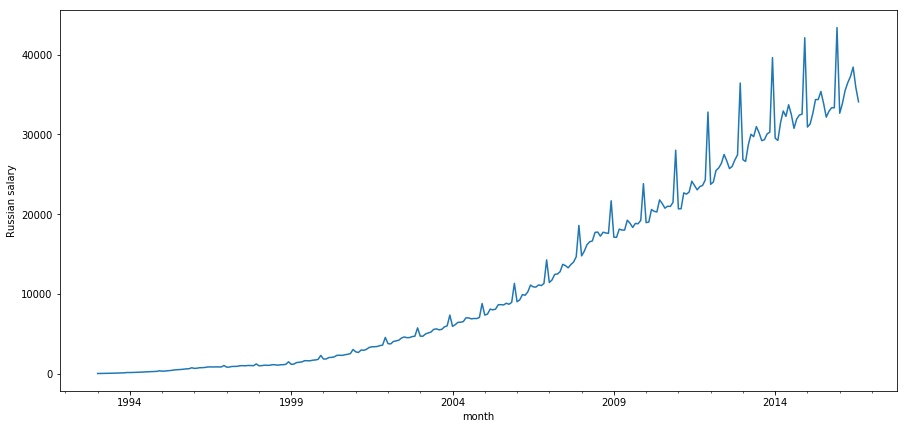

In [10]:
plt.figure(figsize(15,7))
salary.WAG_C_M.plot()
plt.ylabel('Russian salary')
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

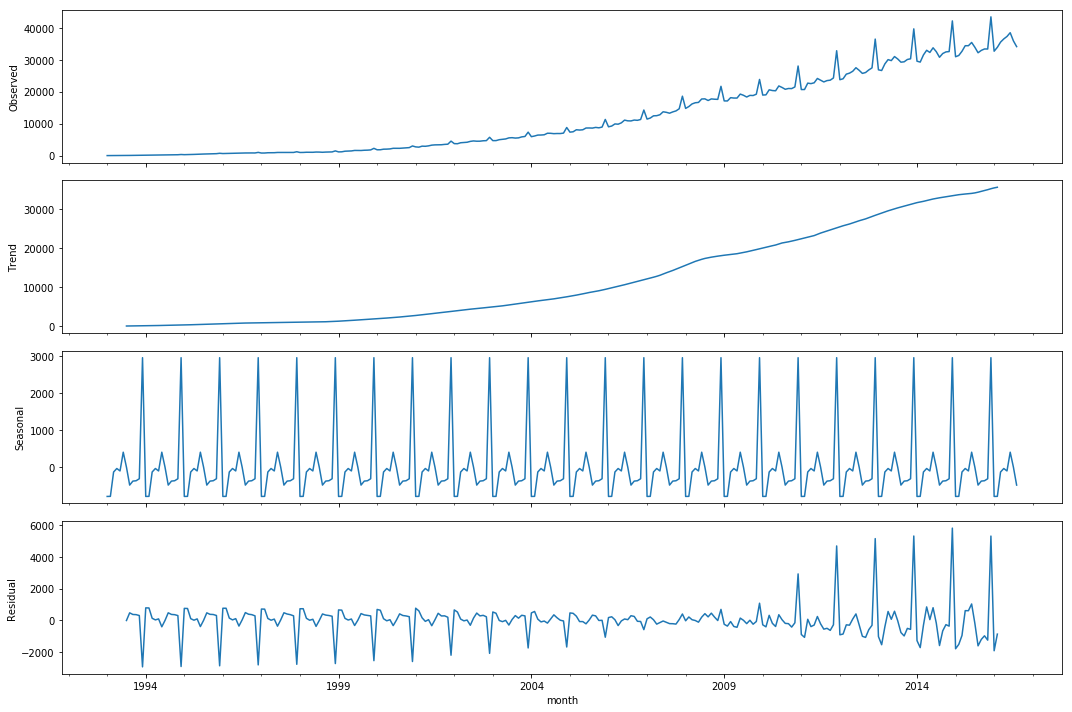

In [12]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_C_M)[1])

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


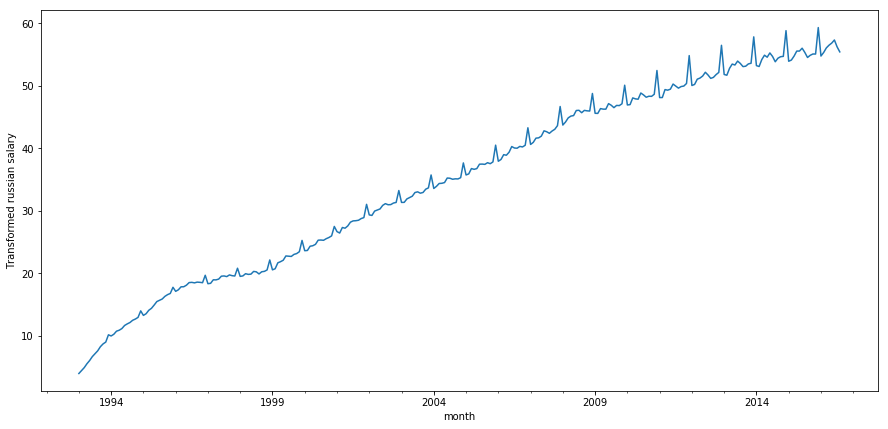

In [13]:
salary['sales_box'], lmbda = stats.boxcox(salary.WAG_C_M)
plt.figure(figsize(15,7))
salary.sales_box.plot()
plt.ylabel(u'Transformed russian salary')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.sales_box)[1])

### Стационарность

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

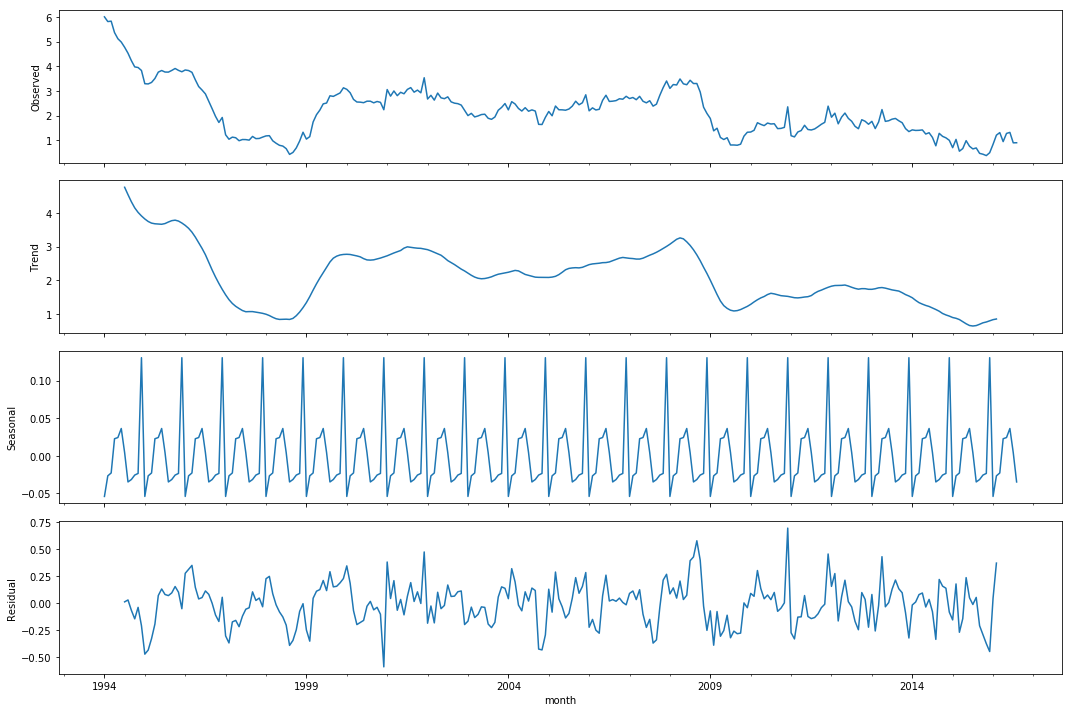

In [14]:
salary['sales_box_diff'] = salary.sales_box - salary.sales_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.sales_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.sales_box_diff[12:])[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

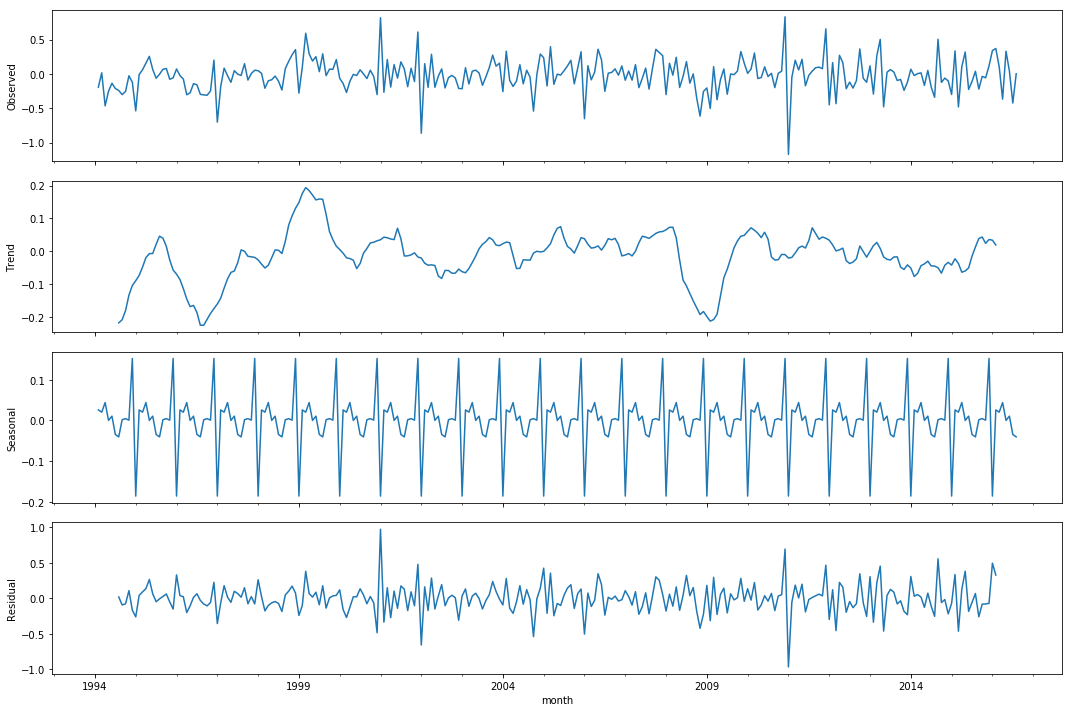

In [16]:
salary['sales_box_diff2'] = salary.sales_box_diff - salary.sales_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.sales_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.sales_box_diff2[13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет.

### Подбор модели

Посмотрим на ACF и PACF полученного ряда:

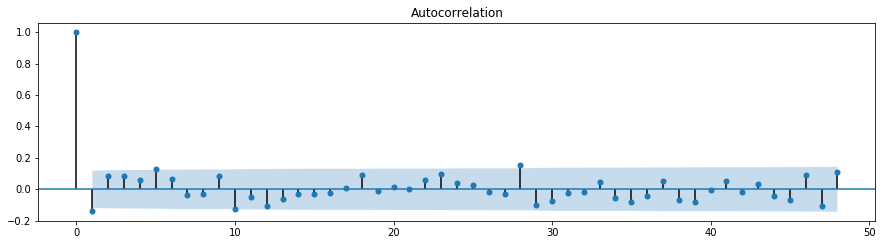

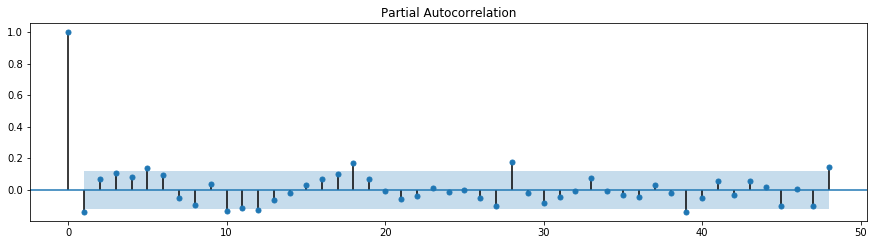

In [19]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary.sales_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary.sales_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q = 0, q = 1, P = 1, p = 10

In [20]:
ps = range(0, 11)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [21]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

88

In [22]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(salary.sales_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 0, 1))
('wrong parameters:', (2, 1, 1, 0))
('wrong parameters:', (2, 1, 1, 1))
Wall time: 47.5 s


In [23]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters       aic
46   (6, 0, 1, 0) -7.552970
47   (6, 0, 1, 1) -7.213253
82  (10, 1, 1, 0) -7.168052
81  (10, 1, 0, 1) -6.746419
45   (6, 0, 0, 1) -6.591533


Лучшая модель:

In [24]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          sales_box   No. Observations:                  284
Model:             SARIMAX(6, 1, 0)x(1, 1, 0, 12)   Log Likelihood                  11.776
Date:                            Sat, 31 Jul 2021   AIC                             -7.553
Time:                                    23:24:14   BIC                             21.264
Sample:                                01-01-1993   HQIC                             4.017
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1991      0.045     -4.401      0.000      -0.288      -0.110
ar.L2          0.0224      0.066   

Её остатки:

Критерий Стьюдента: p=0.293143
Критерий Дики-Фуллера: p=0.000000


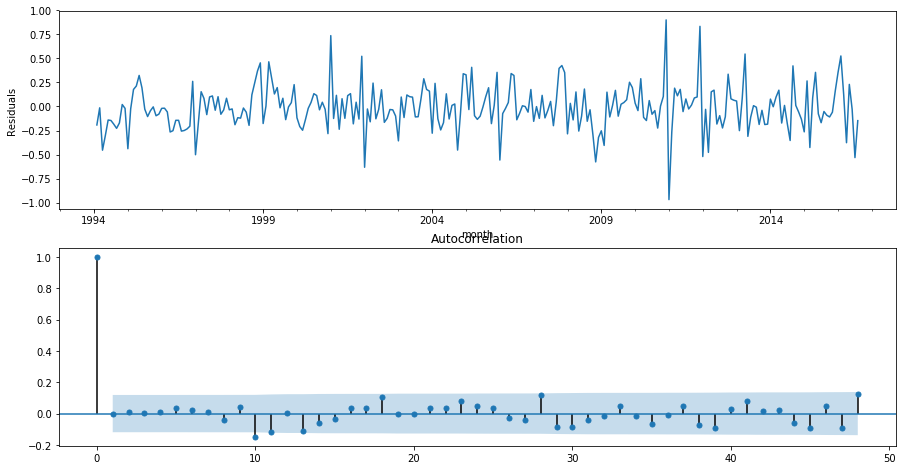

In [25]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

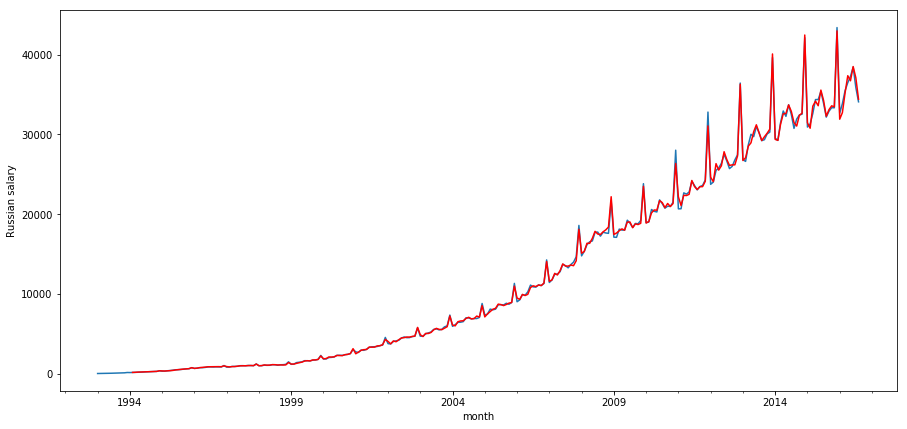

In [26]:
salary['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
salary.WAG_C_M.plot()
salary.model[13:].plot(color='r')
plt.ylabel('Russian salary')
pylab.show()

### Прогноз

In [27]:
?best_model.predict

In [28]:
salary

,WAG_C_M,sales_box,sales_box_diff,sales_box_diff2,model
month,,,,,
1993-01-01,15.3,3.990393,NaN,NaN,1.000000
1993-02-01,19.1,4.458758,NaN,NaN,15.300000
1993-03-01,23.6,4.931635,NaN,NaN,19.100000
1993-04-01,30.6,5.549430,NaN,NaN,23.600000
1993-05-01,37.5,6.063406,NaN,NaN,30.600000
1993-06-01,47.4,6.690719,NaN,NaN,37.500000
1993-07-01,56.0,7.161310,NaN,NaN,47.400000
1993-08-01,65.4,7.618224,NaN,NaN,56.000000
1993-09-01,80.9,8.275619,NaN,NaN,65.400000


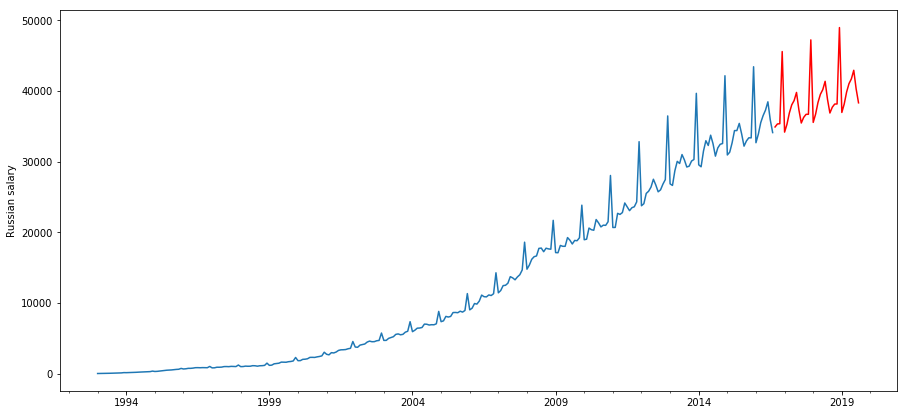

In [33]:
salary2 = salary[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= salary2.columns)
salary2 = pd.concat([salary2, future])
salary2['forecast'] = invboxcox(best_model.predict(start=284, end=319), lmbda)

plt.figure(figsize(15,7))
salary2.WAG_C_M.plot()
salary2.forecast.plot(color='r')
plt.ylabel('Russian salary')
pylab.show()